#**installing libraries**

In [ ]:
!pip install librosa

In [ ]:
!pip install pydub

In [ ]:
!pip install audiomentations --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 2.3 MB/s eta 0:00:00


#**import libraries**

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')


#**connect to drive**

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**reading the dataset**

In [ ]:
Ravdess= "/content/drive/MyDrive/Normal & Abnormal"
ravdess_directory_list = os.listdir(Ravdess)

#**balance the normal & abnormal class**
#the number of datapoints in each class:
- normal      418
- abnormal    185
     - it's not equaled or even class so we have to apply data augmentation on abnormal class to increase the number of data points

In [ ]:
import pandas as pd
import os
from pydub import AudioSegment
from audiomentations import Compose, TimeStretch, PitchShift
import soundfile as sf

# Define data augmentation transformations
augment = Compose([
    TimeStretch(min_rate=0.8, max_rate=1.2, leave_length_unchanged=False),
    PitchShift(min_semitones=-4, max_semitones=4),
])

# Function to apply data augmentation to audio files and save augmented files
def augment_audio_files(file_paths, output_dir, num_augmentations=2):
    for file_path in file_paths:
        # Convert audio file to WAV format
        audio = AudioSegment.from_file(file_path)
        temp_wav_file = os.path.join(output_dir, "temp.wav")
        audio.export(temp_wav_file, format="wav")

        # Read the WAV file using soundfile
        audio, sample_rate = sf.read(temp_wav_file)
        os.remove(temp_wav_file)  # Remove temporary WAV file

        # Transpose audio array if necessary
        if audio.ndim > 1:
            audio = audio.T

        # Apply data augmentation
        for i in range(num_augmentations):
            augmented_audio = augment(samples=audio, sample_rate=sample_rate)

            # Transpose augmented audio back if necessary
            if audio.ndim > 1:
                augmented_audio = augmented_audio.T

            output_file_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_aug_{i}.wav")
            sf.write(output_file_path, augmented_audio, sample_rate)

# Assuming you have your audio files organized in directories
normal_dir = "/content/drive/MyDrive/Normal & Abnormal/normal"
abnormal_dir = "/content/drive/MyDrive/Normal & Abnormal/abnormal"

# Get list of audio files in each directory
normal_audios = [os.path.join(normal_dir, file) for file in os.listdir(normal_dir) if file.endswith('.wav')]
abnormal_audios = [os.path.join(abnormal_dir, file) for file in os.listdir(abnormal_dir) if file.endswith('.wav')]

# Create DataFrames for normal and abnormal classes
df_normal = pd.DataFrame({'file_path': normal_audios, 'emotion': 'normal'})
df_abnormal = pd.DataFrame({'file_path': abnormal_audios, 'emotion': 'abnormal'})

# Calculate the difference in the number of samples between the two classes
num_normal_samples = df_normal.shape[0]
num_abnormal_samples = df_abnormal.shape[0]
difference = num_normal_samples - num_abnormal_samples

# Duplicate samples from the abnormal class to match the size of the normal class
if difference > 0:
    df_abnormal_duplicate = df_abnormal.sample(n=difference, replace=True, random_state=42)
    df_abnormal = pd.concat([df_abnormal, df_abnormal_duplicate], ignore_index=True)

# Apply data augmentation to the abnormal class
augmented_abnormal_dir = "/content/drive/MyDrive/Normal & Abnormal/augmented_abnormal"
os.makedirs(augmented_abnormal_dir, exist_ok=True)
augment_audio_files(abnormal_audios, augmented_abnormal_dir, num_augmentations=2)

# Get list of augmented abnormal audio files
augmented_abnormal_audios = [os.path.join(augmented_abnormal_dir, file) for file in os.listdir(augmented_abnormal_dir) if file.endswith('.wav')]

# Create DataFrame for augmented abnormal class
df_augmented_abnormal = pd.DataFrame({'file_path': augmented_abnormal_audios, 'emotion': 'abnormal'})

# Concatenate the balanced normal DataFrame with the augmented abnormal DataFrame
Ravdess_df = pd.concat([df_normal, df_augmented_abnormal], ignore_index=True)

# Shuffle the concatenated DataFrame
Ravdess_df = Ravdess_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Optional: If you want to check the first few rows of the DataFrame
Ravdess_df.head()


,file_path,emotion
0,/content/drive/MyDrive/Normal & Abnormal/augme...,abnormal
1,/content/drive/MyDrive/Normal & Abnormal/norma...,normal
2,/content/drive/MyDrive/Normal & Abnormal/norma...,normal
3,/content/drive/MyDrive/Normal & Abnormal/norma...,normal
4,/content/drive/MyDrive/Normal & Abnormal/norma...,normal


In [ ]:
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path_copy=data_path.copy()
data_path_copy.head()

,file_path,emotion
0,/content/drive/MyDrive/Normal & Abnormal/augme...,abnormal
1,/content/drive/MyDrive/Normal & Abnormal/norma...,normal
2,/content/drive/MyDrive/Normal & Abnormal/norma...,normal
3,/content/drive/MyDrive/Normal & Abnormal/norma...,normal
4,/content/drive/MyDrive/Normal & Abnormal/norma...,normal


#check the balance of both classes

         
**now**:
*   normal      418
*   abnormal    370



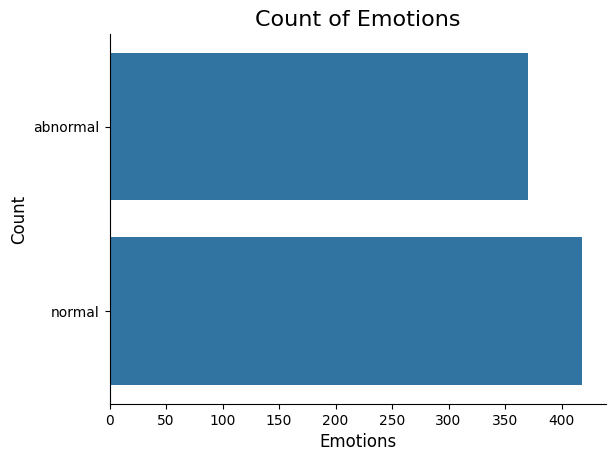

Count of Files in Each Class:
emotion
normal      418
abnormal    370
Name: count, dtype: int64


In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path_copy.emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

print("Count of Files in Each Class:")
print(Ravdess_df['emotion'].value_counts())

#visualize the distribution of the data

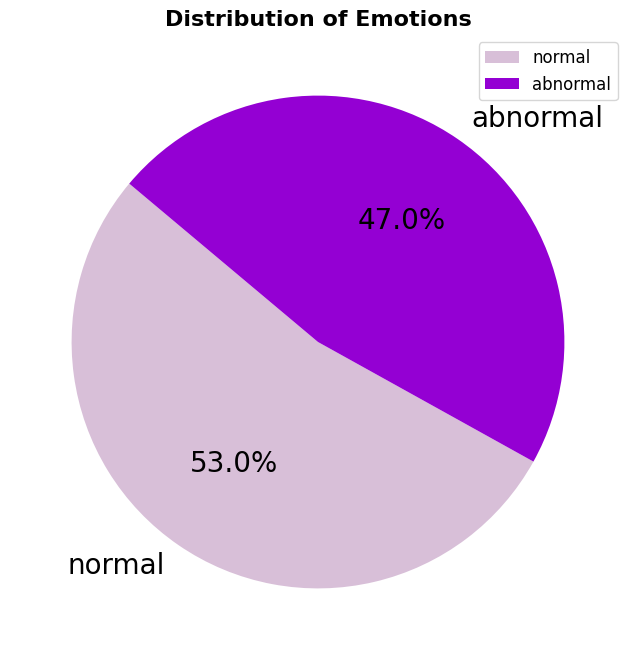

Count of Files in Each Class:
emotion
normal      418
abnormal    370
Name: count, dtype: int64


In [16]:
# Define custom colors
colors = ['thistle', 'darkviolet']

# Plot a pie chart
plt.figure(figsize=(10, 8))
plt.title('Distribution of Emotions', size=16, weight='bold')  # Making the title bold
pie = data_path_copy['emotion'].value_counts().plot.pie(colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 20})  # Increasing font size
plt.ylabel('')

# Add labels on the top right
plt.legend(loc="upper right", labels=data_path_copy['emotion'].value_counts().index, fontsize=12)  # Changing legend font size

plt.show()

print("Count of Files in Each Class:")
print(Ravdess_df['emotion'].value_counts())


#**feature Extraction**

In [18]:
import librosa
import numpy as np

def load_audio(path):
    try:
        # Try loading with librosa directly
        data, sample_rate = librosa.load(path, sr=None)
    except Exception as e:
        # If loading fails, print a warning and use audioread
        print("PySoundFile failed. Trying audioread instead.")
        data, sample_rate = librosa.load(path, sr=None)

    return data, sample_rate

def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)


def extract_features(data, sample_rate):
    result = np.array([])
    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result

def get_features(path):
    data, sample_rate = load_audio(path)

    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))  # stacking vertically

    # data with stretching
    new_data = stretch(data, rate=1.0)
    res3 = extract_features(new_data, sample_rate)
    result = np.vstack((result, res3))  # stacking vertically

    return result

X, Y = [], []
for path, emotion in zip(data_path_copy.file_path, data_path_copy.emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)


In [19]:
len(X), len(Y), data_path_copy.file_path.shape

(2364, 2364, (788,))

In [20]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

#**Data preparation**

In [21]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [22]:
X.shape , Y.shape

((2364, 162), (2364,))

In [23]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [24]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1773, 162), (1773, 2), (591, 162), (591, 2))

In [25]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1773, 162), (1773, 2), (591, 162), (591, 2))

In [26]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1773, 162, 1), (1773, 2), (591, 162, 1), (591, 2))

#**Modeling**
 - ANN

In [27]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define model checkpoint callback to save the best weights
model_checkpoint = ModelCheckpoint(filepath='best_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# Define the model
model = Sequential()

# Flatten the input data
model.add(Flatten(input_shape=(162, 1)))

# Add dense layers
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Output layer with softmax activation for multi-class classification
model.add(Dense(2, activation='sigmoid'))

# Compile the model with custom learning rate
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 162)               0         
                                                                 
 dense (Dense)               (None, 256)               41728     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 83010 (324.26 KB)
Trainable params: 83010 (324.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#model training

In [28]:
# Fit the model to the training data with early stopping and model checkpoint
history = model.fit(x_train, y_train, batch_size=8, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/50
222/222 [==============================] - 7s 13ms/step - loss: 0.6103 - accuracy: 0.6983 - val_loss: 0.4428 - val_accuracy: 0.8071
Epoch 2/50
222/222 [==============================] - 1s 7ms/step - loss: 0.3846 - accuracy: 0.8252 - val_loss: 0.3582 - val_accuracy: 0.8460
Epoch 3/50
222/222 [==============================] - 2s 8ms/step - loss: 0.2997 - accuracy: 0.8742 - val_loss: 0.3099 - val_accuracy: 0.8613
Epoch 4/50
222/222 [==============================] - 1s 4ms/step - loss: 0.2413 - accuracy: 0.9126 - val_loss: 0.2690 - val_accuracy: 0.8917
Epoch 5/50
222/222 [==============================] - 1s 3ms/step - loss: 0.1986 - accuracy: 0.9323 - val_loss: 0.2381 - val_accuracy: 0.9036
Epoch 6/50
222/222 [==============================] - 1s 4ms/step - loss: 0.1605 - accuracy: 0.9475 - val_loss: 0.2022 - val_accuracy: 0.9323
Epoch 7/50
222/222 [==============================] - 1s 3ms/step - loss: 0.1282 - accuracy: 0.9656 - val_loss: 0.1760 - val_accuracy: 0.9492
Epoch

#**ROC & AUC

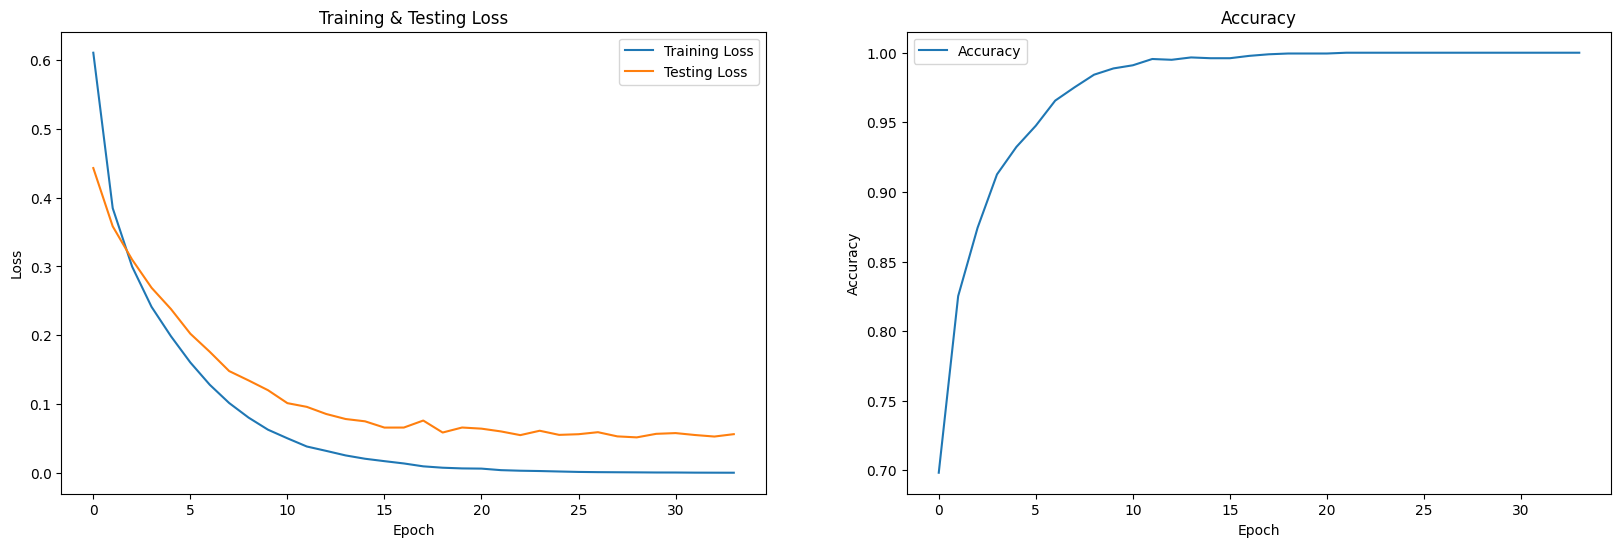

In [29]:
#ANN
epochs = [i for i in range(50)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

# Ensure that epochs, train_loss, and test_loss have the same length
min_length = min(len(epochs), len(train_loss), len(test_loss))
epochs = epochs[:min_length]
train_acc = history.history['accuracy']
train_loss = train_loss[:min_length]
test_loss = test_loss[:min_length]

# Plot the training and testing loss
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Trim the train_acc array to match the length of epochs
train_acc = train_acc[:len(epochs)]

# Assuming you have the necessary arrays: accuracy
# Plot the accuracy
ax[1].plot(epochs, train_acc, label='Accuracy')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

In [30]:
# predicting on test data on ANN.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

19/19 [==============================] - 0s 2ms/step


In [31]:
#ANN
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

,Predicted Labels,Actual Labels
0,normal,normal
1,normal,normal
2,normal,normal
3,normal,normal
4,normal,normal
5,normal,normal
6,normal,normal
7,abnormal,abnormal
8,abnormal,abnormal
9,abnormal,abnormal


#**function to record audio from the user**

In [33]:
from google.colab import output

def record_audio(duration):
    print("Recording...")
    output.clear(output_tags='audio')
    js_code = f'''
    async function recordAudio(duration) {{
        const recorder = new MediaRecorder(await navigator.mediaDevices.getUserMedia({{ audio: true }}));
        const audioChunks = [];

        recorder.addEventListener('dataavailable', event => {{
            audioChunks.push(event.data);
        }});

        recorder.addEventListener('stop', () => {{
            const audioBlob = new Blob(audioChunks, {{ type: 'audio/wav' }});
            const reader = new FileReader();
            reader.onload = function() {{
                const arrayBuffer = reader.result;
                const byteArray = new Uint8Array(arrayBuffer);
                google.colab.kernel.invokeFunction('saveAudio', [Array.from(byteArray)]);
            }};
            reader.readAsArrayBuffer(audioBlob);
        }});

        recorder.start();
        await new Promise(resolve => setTimeout(resolve, duration * 1000));
        recorder.stop();
    }}
    recordAudio({duration});
    '''

    output.register_callback('saveAudio', lambda audio_data: save_audio(audio_data))

    output.eval_js(js_code)

def save_audio(audio_data):
    try:
        import os
        os.makedirs("/content/record", exist_ok=True)

        with open('/content/record/recorded_audio.wav', 'wb') as f:
            f.write(bytearray(audio_data))
        print("Audio saved successfully to /content/record/recorded_audio.wav")
    except Exception as e:
        print("An error occurred while saving audio:", str(e))




#**make prediction on the input record**

- taking audio input from the user
- applying feature extraion & preprocessing from it
- predict using the model

In [35]:
import numpy as np
from scipy.io import wavfile
from tensorflow.keras.preprocessing import sequence


record_audio(5)

# Preprocess the recorded audio
audio_file_path = '/content/record/recorded_audio.wav'
# preprocessed_audio = preprocess_audio(audio_file_path)

# Extract features from the preprocessed audio
features = get_features(audio_file_path)

# Apply the same preprocessing steps as done for training data
scaler = StandardScaler()
preprocessed_features = scaler.fit_transform(features)
preprocessed_features = np.expand_dims(preprocessed_features, axis=2)

# Predict using the model
prediction = model.predict(preprocessed_features)

# Calculate the scores for each class
class_scores = np.max(prediction, axis=0)

# Extract the class with the maximum score
predicted_class = np.argmax(class_scores)

# If you have class labels, you can map the predicted class to the label
# Replace class_labels with your actual class labels
class_labels = ['abnormal', 'normal']

predicted_label = class_labels[predicted_class]

print("Predicted Label:", predicted_label)



Recording...
1/1 [==============================] - 0s 43ms/step
Predicted Label: normal
Audio saved successfully to /content/record/recorded_audio.wav


In [ ]:
# # Step 1: Save your Keras model
# from keras.models import load_model

# # Assuming your model is already defined and trained
# model.save('my_keras_model.h5')

# # Step 2: Convert the model to ONNX format
# import tensorflow as tf
# import tf2onnx

# # Load the Keras model
# keras_model = load_model('my_keras_model.h5')

# # Convert Keras model to ONNX format
# onnx_model, _ = tf2onnx.convert.from_keras(keras_model)

# # Save ONNX model to file
# with open('my_onnx_model.onnx', 'wb') as f:
#     f.write(onnx_model.SerializeToString())

# print("Conversion to ONNX format completed successfully.")

Conversion to ONNX format completed successfully.


In [ ]:
# model.save("my_model.keras")